In [1]:
import astropy.units as u
import numpy as np
import pandas as pd
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
import math

def GAIA_query(ra0,dec0,mag_limit):
    job = Gaia.launch_job_async("SELECT *     FROM gaiadr3.gaia_source     WHERE CONTAINS(POINT(gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE("+str(ra0)+","+str(dec0)+","+str(10/60)+"))=1     AND phot_g_mean_mag IS NOT NULL     AND parallax IS NOT NULL     ORDER BY phot_g_mean_mag ASC;", dump_to_file=False)

    GAIA_data = job.get_results()
    
    ra=[]
    dec=[]
    mag=[]
    
    for i in range(0,len(GAIA_data)):
        if GAIA_data['phot_g_mean_mag'][i]<=mag_limit:
            mag.append(GAIA_data['phot_g_mean_mag'][i])
            ra.append(GAIA_data['ra'][i])
            dec.append(GAIA_data['dec'][i])

    scales=[] #Need scale values for the marker size of each star to illustrate magnitude on a plot

    for i in mag: #Scale is linear with magnitude from {16}, i.e mag {12} star has marker size {2} times larger than a mag {14} star.
        I=(mag_limit-i)
        scales.append(I*10)

    stars_data=pd.DataFrame({'ra':ra,'dec':dec,'mag':mag,'scale':scales}) #naturally sorted by magnitude

    input_data={}
    input_data['mag_limit']=mag_limit
    input_data['source']="query"
    input_data['ra0']=ra0 * u.deg
    input_data['dec0']=dec0 * u.deg

    return stars_data,input_data



Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
data,input_data=GAIA_query(54.1,-27.8,18)

INFO: Query finished. [astroquery.utils.tap.core]


In [47]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import time

class FOV_stars: #Class for the FOV simulation
    def __init__(self,stars_data,input_data):
        self.stars_data=stars_data.copy() #Pandas DataFrame of the stars' data. Stores ra, dec, mag, and "scale" (for graphical plotting)
        self.input_data=input_data

        self.const={}
        self.const['inner_annulus_D']=7.4 * u.arcsec
        self.const['inner_circle_D']=5 * u.arcsec
        self.const['outer_annulus_D']=10 * u.arcsec
        self.const['LGS_radial_D']=7.4 * u.arcsec
        self.const['LGS_D']=2.2 * u.arcsec 
        self.const['PFS_arm_width']=0.5 * u.arcsec
        self.const['PFS_arm_length']=0.5 * u.arcsec
        self.const['PFS_arm_ang_sep']=45 * u.deg
        self.const['PFS_stars_min_mag']=15.5
        self.const['NGS_stars_min_sep']=1 * u.arcsec
        self.const['NGS_stars_min_mag']=17

    def orthographic(self,ra,dec,ra0,dec0): #Orthographic projection plane around ra0 and dec0
        x=np.cos(dec)*np.sin(ra-ra0)
        y=np.cos(dec0)*np.sin(dec)-np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)
        return x,y

    def distance(self,A,B): #Distance between points A and B:
        d=np.sqrt((A[0]-B[0])**2+(A[1]-B[1])**2)
        return d  
    
    def line(self,A,B): #Returns gradient (m) and y intercept (c) of a line joining points A and B, form y=m*x+c
        m=(A[1]-B[1])/(A[0]-B[0])
        c=A[1]-m*A[0] 
        return m,c

    def perp_line(self,m,c,C): #Returns gradient and y intercept of a line perpendicular to y=m*x+c going through C
        m_perp=-1/m
        c_perp=C[1]-m_perp*C[0]
        return m_perp,c_perp   
   
    def convert_stars_to_xy(self,ra0,dec0):
        ra0=ra0.to(u.rad).value
        dec0=dec0.to(u.rad).value

        self.stars_data['x'],self.stars_data['y']=self.orthographic(np.radians(self.stars_data['ra']),np.radians(self.stars_data['dec']),ra0,dec0) #Angles need to be in radians
        void,self.arcmin_in_xy=self.orthographic(ra0,dec0+ np.radians(1/60),ra0,dec0) #Length of 1 arcmin in the x,y projection units: used as a scale for conversion

        self.const['outer_annulus_xyD']=self.const['outer_annulus_D']*self.arcmin_in_xy #Using the 1 arcmin length in x,y, converts the outer annulus diameter to x,y units
        self.const['inner_annulus_xyD']=self.const['inner_annulus_D']*self.arcmin_in_xy #Using the 1 arcmin length in x,y, converts the inner annulus diameter to x,y units
        self.const['inner_circle_xyD']=self.const['inner_circle_D']*self.arcmin_in_xy #Using the 1 arcmin length in x,y, converts the inner circle diameter to x,y units
       
        return
   
    def find_stars_zones(self,x_offset=0,y_offset=0):
        #3 for inner circle, 2 for inner annulus, 1 for outer annulus, 0 for none
        zones=[]
        for i in range(0,len(self.stars_data)):
            dist = self.distance([self.stars_data['x'][i],self.stars_data['y'][i]],[0-x_offset,0-y_offset])
            if dist < self.const['outer_annulus_xyD'].value/2:
                if dist < self.const['inner_annulus_xyD'].value/2:
                    if dist < self.const['inner_circle_xyD'].value/2:
                        zones.append(1)
                    else: 
                        zones.append(2)
                else:
                    zones.append(3)
            else:
                zones.append(4)

        self.stars_data['zone']=zones

        return

    def find_PFS(self):
        PFS_arm_xywidth=self.const['PFS_arm_width'].value*self.arcmin_in_xy #Distance from PFS star to edge of PFS arm widthways in x,y units
        PFS_arm_xylength=self.const['PFS_arm_length'].value*self.arcmin_in_xy #Distance from PFS star to end of PFS arm in x,y units
        
        self.stars_data['label']=""

        #available star = 0, PFS star = "S_PFS", obscured by PFS = "O_PFS", obscured by both LGS and PFS = "O_PFS_LGS", obscured by LGS = "O_LGS", NGS = "S_NGS"
        angles=[]
        PFS_arms = [[],[],[]]    

        for i in self.stars_data.loc[(self.stars_data['zone']==3) | (self.stars_data['zone']==2)].index:
            if self.stars_data['mag'][i]<self.const['PFS_stars_min_mag']:
                theta=math.atan2(self.stars_data['x'][i],self.stars_data['y'][i])
                
                if all(abs(theta - val )  > self.const['PFS_arm_ang_sep'].to(u.rad).value for val in angles):
                    self.stars_data.at[i,'label']="S_PFS"

                    A=(self.stars_data['x'][i]-PFS_arm_xylength*np.sin(theta)+PFS_arm_xywidth*np.cos(theta),
                    self.stars_data['y'][i]-PFS_arm_xylength*np.cos(theta)-PFS_arm_xywidth*np.sin(theta))
                    B=(self.stars_data['x'][i]-PFS_arm_xylength*np.sin(theta)-PFS_arm_xywidth*np.cos(theta),
                    self.stars_data['y'][i]-PFS_arm_xylength*np.cos(theta)+PFS_arm_xywidth*np.sin(theta))

                    AB_m,AB_c=self.line(A,B)
                    AD_m,AD_c=self.perp_line(AB_m,AB_c,A)
                    BC_m,BC_c=self.perp_line(AB_m,AB_c,B)

                    #Following calculates C and D positions, the origins of the PFS arms: they "originate" at the top/bottom of the FOV boundary
                    if np.pi/2>theta>-np.pi/2: #Ifs PFS star in top half, origins are at y=+FOV boundary
                        C=((self.const['outer_annulus_xyD'].value/2-BC_c)/BC_m,self.const['outer_annulus_xyD'].value/2)
                        D=((self.const['outer_annulus_xyD'].value/2-AD_c)/AD_m,self.const['outer_annulus_xyD'].value/2) 
                    else: #If PFS star in bottom half, origins are at y=-FOV boundary
                        C=((-self.const['outer_annulus_xyD'].value/2-BC_c)/BC_m,-self.const['outer_annulus_xyD'].value/2)
                        D=((-self.const['outer_annulus_xyD'].value/2-AD_c)/AD_m,-self.const['outer_annulus_xyD'].value/2)   

                    PFS_arms[len(angles)]=[A,B,C,D,AB_m,AB_c,AD_m,AD_c,BC_m,BC_c]
                    angles.append(theta)               

            if len(angles)==3:
                break

        self.PFS_arms=pd.DataFrame(PFS_arms,columns=['A','B','C','D','AB_m','AB_c','AD_m','AD_c','BC_m','BC_c'])

        for i in self.stars_data.loc[(self.stars_data['label']!="S_PFS")].index:
            starx=self.stars_data['x'][i]
            stary=self.stars_data['y'][i]
            for o, theta in enumerate(angles): #Checks each star against each PFS arm
                AB_m,AB_c=self.PFS_arms['AB_m'][o],self.PFS_arms['AB_c'][o]
                AD_m,AD_c=self.PFS_arms['AD_m'][o],self.PFS_arms['AD_c'][o]
                BC_m,BC_c=self.PFS_arms['BC_m'][o],self.PFS_arms['BC_c'][o]

                #The orientation of the arms sides depends on the star's angle/quadrant, and this alters the inequality conditions for vignetting
                if 0>theta>-np.pi/2 and stary>AB_m*starx+AB_c and stary<AD_m*starx+AD_c and stary>BC_m*starx+BC_c:
                        self.stars_data.at[i,'label']="O_PFS"
                elif -np.pi/2>theta>-np.pi and stary<AB_m*starx+AB_c and stary<AD_m*starx+AD_c and stary>BC_m*starx+BC_c:
                        self.stars_data.at[i,'label']="O_PFS"
                elif np.pi>theta>np.pi/2 and stary<AB_m*starx+AB_c and stary>AD_m*starx+AD_c and stary<BC_m*starx+BC_c:
                        self.stars_data.at[i,'label']="O_PFS"
                elif np.pi/2>theta>0 and stary>AB_m*starx+AB_c and stary>AD_m*starx+AD_c and stary<BC_m*starx+BC_c:
                        self.stars_data.at[i,'label']="O_PFS"
        
        return 

    def find_LGS(self,LGS_angle):      
        self.const['LGS_xyD']=self.const['LGS_D'].value*self.arcmin_in_xy #Distance of LGS footprints from FOV centre in x,y units
        self.const['LGS_radial_xyD']=self.const['LGS_radial_D'].value*self.arcmin_in_xy #Radius of LGS footprint in x,y units
        
        #Following calculates the x and y positions of the 4 LGS footprints using the LGS angle and LGS distance from FOV centre
        LGS_pos=[[self.const['LGS_radial_xyD']/2*np.sin(LGS_angle),self.const['LGS_radial_xyD']/2*np.cos(LGS_angle)],[self.const['LGS_radial_xyD']/2*np.sin(LGS_angle+np.pi/2),self.const['LGS_radial_xyD']/2*np.cos(LGS_angle+np.pi/2)],
                [self.const['LGS_radial_xyD']/2*np.sin(LGS_angle+np.pi),self.const['LGS_radial_xyD']/2*np.cos(LGS_angle+np.pi)],[self.const['LGS_radial_xyD']/2*np.sin(LGS_angle+3*np.pi/2),self.const['LGS_radial_xyD']/2*np.cos(LGS_angle+3*np.pi/2)]]

        self.const["LGS_pos"]=LGS_pos
        #Following takes x,y of each FOV star not vignetted by PFS arms and identifies if they are within the equation of a circle for the LGS footprints
        for i in range(0,len(self.stars_data)):
            for o in range(0,4):
                if (self.stars_data['x'][i]-LGS_pos[o][0])**2+(self.stars_data['y'][i]-LGS_pos[o][1])**2<(self.const['LGS_xyD']/2)**2:
                    self.stars_data.at[i,'label']=self.stars_data.at[i,'label']+"O_LGS"
                                            
        return

    def find_NGS(self,override=True):
        potential =  self.stars_data.loc[((self.stars_data['zone']==1) | (self.stars_data['zone']==2)) & (self.stars_data['label']=="") & (self.stars_data['mag'] < self.const['NGS_stars_min_mag'])].index

        if len(potential) == 0: #Stops function from breaking
            print("No Potential NGS Stars")
            potential=[]
            return

        confirmed=[potential[0]]
        for i in range(1,len(potential)):
            if abs(self.distance([self.stars_data['x'][confirmed[0]]-self.stars_data['x'][potential[i]],self.stars_data['y'][confirmed[0]]-self.stars_data['y'][potential[i]]],[0,0]))>self.const['NGS_stars_min_sep'].value*self.arcmin_in_xy: #SCALE!!!
                confirmed.append(potential[i])
                break

        for o in range(i,len(potential)):
            if (abs(self.distance([self.stars_data['x'][confirmed[0]]-self.stars_data['x'][potential[o]],self.stars_data['y'][confirmed[0]]-self.stars_data['y'][potential[o]]],[0,0]))>self.const['NGS_stars_min_sep'].value*self.arcmin_in_xy
            and abs(self.distance([self.stars_data['x'][confirmed[1]]-self.stars_data['x'][potential[o]],self.stars_data['y'][confirmed[1]]-self.stars_data['y'][potential[o]]],[0,0]))>self.const['NGS_stars_min_sep'].value*self.arcmin_in_xy):
                confirmed.append(potential[o])
                break

        for i in confirmed:
            self.stars_data.at[i,'label']="S_NGS"
        
        return

    def find_NGS_stats(self):
        NGS_stars=self.stars_data.loc[self.stars_data['labels']=="S_NGS"].index
        print(NGS_stars)
        return

    def find_PFS_overlap(self):
        return

    def plot(self):
        fig, ax = plt.subplots(figsize=(10,10))
        FOV_techfield = plt.Circle((0,0),self.const['outer_annulus_xyD'].value/2, color='gray', alpha=0.4) #Technical field FOV
        FOV_sciencefield = plt.Circle((0,0),self.const['inner_annulus_xyD'].value/2, color='orange', alpha=0.4) #Science field FOV
        FOV_PFSboundary = plt.Circle((0,0),self.const['inner_circle_xyD'].value/2,color='black',fill=False,alpha=0.4)
        ax.add_patch(FOV_techfield)
        ax.add_patch(FOV_sciencefield)
        ax.add_patch(FOV_PFSboundary)

        for i in range(0,4):
            LGS=plt.Circle((self.const['LGS_pos'][i][0],self.const['LGS_pos'][i][1]),self.const['LGS_xyD']/2, color='red', alpha=0.2)
            ax.add_patch(LGS)

        for i in range(0,len(self.stars_data)):
        
            if self.stars_data['zone'][i]==4:
                plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='grey',s=self.stars_data['scale'][i])
            if self.stars_data['zone'][i]==3:
                if self.stars_data['label'][i]=="S_PFS" or self.stars_data['label'][i]=="S_PFSO_LGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='black',s=self.stars_data['scale'][i])
                elif self.stars_data['label'][i]=="O_PFS" or self.stars_data['label'][i]=="O_LGS" or self.stars_data['label'][i]=="O_PFSO_LGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='red',s=self.stars_data['scale'][i])
                else:
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='brown',s=self.stars_data['scale'][i])
            if self.stars_data['zone'][i]==2:
                if self.stars_data['label'][i]=="S_PFS" or self.stars_data['label'][i]=="S_PFSO_LGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='black',s=self.stars_data['scale'][i])
                elif self.stars_data['label'][i]=="O_PFS" or self.stars_data['label'][i]=="O_LGS" or self.stars_data['label'][i]=="O_PFSO_LGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='red',s=self.stars_data['scale'][i])
                elif self.stars_data['label'][i]=="S_NGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='blue',s=self.stars_data['scale'][i])
                else:
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='green',s=self.stars_data['scale'][i])
            if self.stars_data['zone'][i]==1:
                if self.stars_data['label'][i]=="O_PFS" or self.stars_data['label'][i]=="O_LGS" or self.stars_data['label'][i]=="O_PFSO_LGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='red',s=self.stars_data['scale'][i])
                elif self.stars_data['label'][i]=="S_NGS":
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='blue',s=self.stars_data['scale'][i])
                else:
                    plt.scatter(self.stars_data['x'][i],self.stars_data['y'][i],color='green',s=self.stars_data['scale'][i])

        confirmed= self.stars_data.loc[(self.stars_data['label']=="S_NGS")].index
        plt.plot([self.stars_data['x'][confirmed[0]],self.stars_data['x'][confirmed[1]]],[self.stars_data['y'][confirmed[0]],self.stars_data['y'][confirmed[1]]],color='blue')
        plt.plot([self.stars_data['x'][confirmed[1]],self.stars_data['x'][confirmed[2]]],[self.stars_data['y'][confirmed[1]],self.stars_data['y'][confirmed[2]]],color='blue')
        plt.plot([self.stars_data['x'][confirmed[2]],self.stars_data['x'][confirmed[0]]],[self.stars_data['y'][confirmed[2]],self.stars_data['y'][confirmed[0]]],color='blue')

        plt.ylim(-self.const['outer_annulus_xyD'].value/2,self.const['outer_annulus_xyD'].value/2)
        plt.xlim(-self.const['outer_annulus_xyD'].value/2,self.const['outer_annulus_xyD'].value/2)

        for i in range(0,len(self.PFS_arms)):
            plt.plot([self.PFS_arms['A'][i][0],self.PFS_arms['B'][i][0]],[self.PFS_arms['A'][i][1],self.PFS_arms['B'][i][1]],color='red')
            plt.plot([self.PFS_arms['A'][i][0],self.PFS_arms['D'][i][0]],[self.PFS_arms['A'][i][1],self.PFS_arms['D'][i][1]],color='red')
            plt.plot([self.PFS_arms['B'][i][0],self.PFS_arms['C'][i][0]],[self.PFS_arms['B'][i][1],self.PFS_arms['C'][i][1]],color='red')

        for i in self.stars_data.index:
            ax.annotate(round(self.stars_data['mag'][i],1),(self.stars_data['x'][i],self.stars_data['y'][i]),xytext=(5, 5),textcoords="offset pixels")

        for i in range(0,4):
            ax.annotate("LGS {}".format(i+1),(self.const['LGS_pos'][i][0]+0.00005,self.const['LGS_pos'][i][1]))       


        plt.scatter(0,0,marker='+',color='black')   

        ticks = np.linspace(-self.const['outer_annulus_xyD'].value/2,+self.const['outer_annulus_xyD'].value/2,21)
        ticks_labels = np.linspace(-5,5,21)
        

        plt.yticks(ticks)
        plt.xticks(ticks)

        ax.set_xticklabels(ticks_labels)
        ax.set_yticklabels(ticks_labels)

        plt.ylabel("arcmin")
        plt.xlabel("arcmin")

        plt.gca().invert_xaxis()



[8, 18, 26]


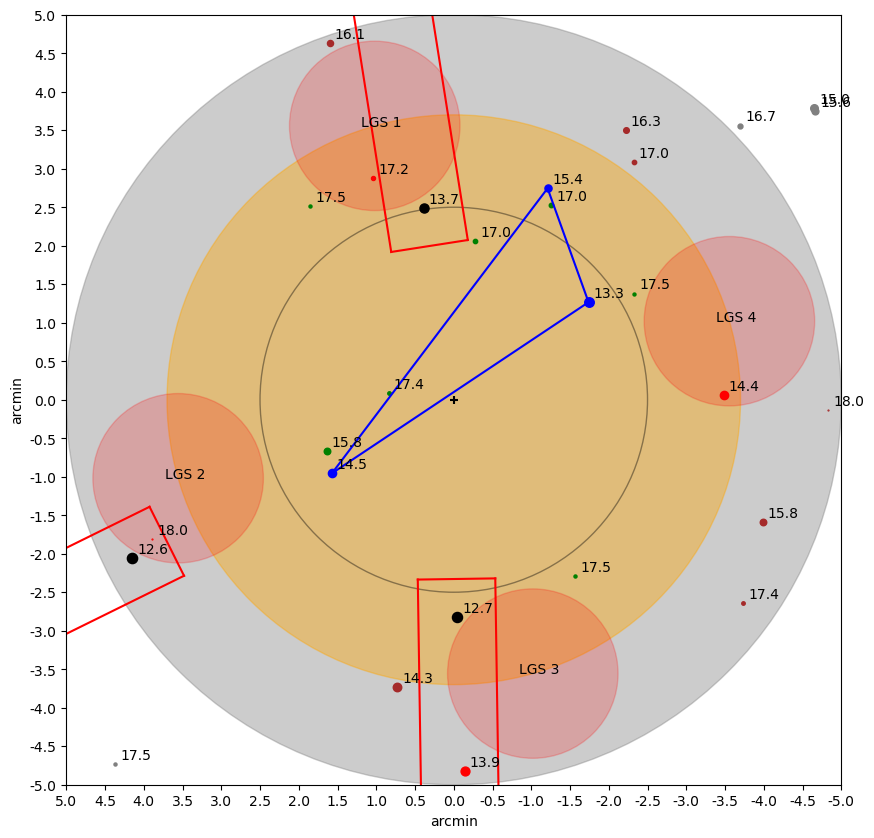

In [49]:
a=FOV_stars(data,input_data)
a.convert_stars_to_xy(input_data['ra0'],input_data['dec0'])
a.find_stars_zones()
a.find_PFS()
a.find_LGS(np.radians(16))
a.find_NGS()
a.find_NGS_stats()
a.plot()

In [5]:
            # if len(NGSstars_index)==0: #If there are no suitable NGS stars, return no area and barycentre
            #     NGSstars_index=[]
            #     return 0,0,NGSchosen_index,NGSfaint_index,NGSnonchosen_index
            
            # NGSstars_mag, NGSstars_index = zip(*sorted(zip(NGSstars_mag,NGSstars_index))) #Sorts the lists by magnitude, so brightest stars are first        
            # NGSstars_mag=list(NGSstars_mag) #Need the stars magnitudes in a list, last line returns a tuple
            # NGSstars_index=list(NGSstars_index) #Need the the stars indexes in a list, last line returns a tuple
            
            # if len(NGSstars_index)>=3: #If there are 3 or more available NGS stars, see if they obey the min distance constraint
            #     NGSchosen_index.append(NGSstars_index[0]) #Brightest star is of course avaiable for asterism
            #     for i in range(1,len(NGSstars_index)): #This loop finds the next brightest star that obeys the distance constraint
            #         if abs(self.distance(self.stars_data['x'][NGSchosen_index[0]]-self.stars_data['x'][NGSstars_index[i]],self.stars_data['y'][NGSchosen_index[0]]-self.stars_data['y'][NGSstars_index[i]]))>self.NGSstars_mindistance*self.onearcmin_xy:
            #             NGSchosen_index.append(NGSstars_index[i]) #If found, add to the chosen NGS star list for the asterism
            #             break

            #     for o in range(i,len(NGSstars_index)): #This loops finds the next brightest star that obeys the distance constraints for both the previous asterism stars
            #         if (abs(self.distance(self.stars_data['x'][NGSchosen_index[0]]-self.stars_data['x'][NGSstars_index[o]],self.stars_data['y'][NGSchosen_index[0]]-self.stars_data['y'][NGSstars_index[o]]))>self.NGSstars_mindistance*self.onearcmin_xy 
            #         and abs(self.distance(self.stars_data['x'][NGSchosen_index[1]]-self.stars_data['x'][NGSstars_index[o]],self.stars_data['y'][NGSchosen_index[1]]-self.stars_data['y'][NGSstars_index[o]]))>self.NGSstars_mindistance*self.onearcmin_xy):
            #             NGSchosen_index.append(NGSstars_index[o]) #If found, add to the chosen NGS star list for the asterism
            #             break
            #     #The result of the last loops is that either 1, 2, or 3 stars have been found which obey the distance constraint

            #     if len(NGSchosen_index)==3: #If three have been found, these are used for the asterism
            #         a,b,c=NGSchosen_index[0],NGSchosen_index[1],NGSchosen_index[2] #Three asterism stars are labelled a,b,c
            #         NGSstars_index.remove(a),NGSstars_index.remove(b),NGSstars_index.remove(c) #These 3 stars are removed from the NGSstars index list
            #         NGSnonchosen_index=NGSstars_index #This NGSstars index list then contains the non chosen viable stars
            #         #Area is found using the Shoelace formula
            #         NGSasterism_area=((self.stars_data['x'][a]*self.stars_data['y'][b]+self.stars_data['x'][b]*self.stars_data['y'][c]+self.stars_data['x'][c]*self.stars_data['y'][a]
            #                         -self.stars_data['y'][a]*self.stars_data['x'][b]-self.stars_data['y'][b]*self.stars_data['x'][c]-self.stars_data['y'][c]*self.stars_data['x'][a])/(2*self.onearcmin_xy**2))
            #         #Barycentre x/y is average of x/y co-ords of the 3 points
            #         NGSasterism_barycentre=[(self.stars_data['x'][a]+self.stars_data['x'][b]+self.stars_data['x'][c])/3,(self.stars_data['y'][a]+self.stars_data['y'][b]+self.stars_data['y'][c])/3]  
            #         return abs(NGSasterism_area),NGSasterism_barycentre,NGSchosen_index,NGSfaint_index,NGSnonchosen_index
                
            #     else: #If three haven't been found within the constraint, then either we can override the constraint or accept it and have only a two or one star asterism
            #         if override==True:
            #             print("Minimum NGS distance overridden")
            #             a,b,c=NGSstars_index[0], NGSstars_index[1],NGSstars_index[2] #If constraint is overridden, we pick the 3 brightest stars
            #             NGSstars_index.remove(a),NGSstars_index.remove(b),NGSstars_index.remove(c)
            #             NGSnonchosen_index=NGSstars_index
            #             NGSchosen_index=[a,b,c]
            #             #Area is found using the Shoelace formula
            #             NGSasterism_area=((self.stars_data['x'][a]*self.stars_data['y'][b]+self.stars_data['x'][b]*self.stars_data['y'][c]+self.stars_data['x'][c]*self.stars_data['y'][a]
            #                             -self.stars_data['y'][a]*self.stars_data['x'][b]-self.stars_data['y'][b]*self.stars_data['x'][c]-self.stars_data['y'][c]*self.stars_data['x'][a])/(2*self.onearcmin_xy**2))
            #             #Barycentre x/y is average of x/y co-ords of the 3 points
            #             NGSasterism_barycentre=[(self.stars_data['x'][a]+self.stars_data['x'][b]+self.stars_data['x'][c])/3,(self.stars_data['y'][a]+self.stars_data['y'][b]+self.stars_data['y'][c])/3] 
            #             return abs(NGSasterism_area),NGSasterism_barycentre,NGSchosen_index,NGSfaint_index,NGSnonchosen_index

            #         if override==False: #If we do not override, then use the stars that obey the constraint in a two or one star asterism
            #             if len(NGSchosen_index)==2: #If there are 2 available NGS stars within constraints, calculate the barycentre
            #                 a=NGSchosen_index[0]
            #                 b=NGSchosen_index[1]
            #                 NGSstars_index.remove(a)
            #                 NGSstars_index.remove(b)
            #                 NGSnonchosen_index=NGSstars_index
            #                 NGSasterism_barycentre=[(self.stars_data['x'][a]+self.stars_data['x'][b])/2,(self.stars_data['y'][a]+self.stars_data['y'][b])/2]  
            #                 return 0,NGSasterism_barycentre,NGSchosen_index,NGSfaint_index,NGSnonchosen_index

            #             elif len(NGSchosen_index)==1: #If there is 1 available NGS star within constraints, return its' co-ordinates
            #                 a=NGSchosen_index[0]
            #                 NGSstars_index.remove(a)
            #                 NGSnonchosen_index=NGSstars_index
            #                 NGSasterism_barycentre=[self.stars_data['x'][a],self.stars_data['x'][b]]    
            #                 return 0, NGSasterism_barycentre,NGSchosen_index,NGSfaint_index,NGSnonchosen_index

            # elif len(NGSstars_index)==2: #If there are 2 only available NGS stars, see if they obey the constraint. If they do, use a 2 star asterism
            #     if abs(self.distance(self.stars_data['x'][NGSstars_index[0]]-self.stars_data['x'][NGSstars_index[1]],self.stars_data['y'][NGSstars_index[0]]-self.stars_data['y'][NGSstars_index[1]]))>self.NGSstars_mindistance*self.onearcmin_xy:
            #             a=NGSstars_index[0]
            #             b=NGSstars_index[1]
            #             NGSchosen_index=[a,b]
            #             NGSasterism_barycentre=[(self.stars_data['x'][a]+self.stars_data['x'][b])/2,(self.stars_data['y'][a]+self.stars_data['y'][b])/2]  
            #             return 0,NGSasterism_barycentre,NGSchosen_index,NGSfaint_index,NGSnonchosen_index
            #     else: #If they dont obey the constraint, we can override the constraint and use the 2 star asterism, or obey the constraint and use a one star asterism
            #         if override==True:
            #             a=NGSstars_index[0]
            #             b=NGSstars_index[1]
            #             NGSchosen_index=[a,b]
            #             NGSasterism_barycentre=[(self.stars_data['x'][a]+self.stars_data['x'][b])/2,(self.stars_data['y'][a]+self.stars_data['y'][b])/2]  
            #             return 0,NGSasterism_barycentre,NGSchosen_index,NGSfaint_index,NGSnonchosen_index
            #         if override==False:
            #             a=NGSstars_index[0]
            #             NGSchosen_index=[a]
            #             NGSasterism_barycentre=[self.stars_data['x'][a],self.stars_data['x'][b]]    
            #             return 0, NGSasterism_barycentre,NGSchosen_index,NGSfaint_index,NGSnonchosen_index
            
            # elif len(NGSstars_index)==1: #If there is 1 available NGS star, return its' co-ordinates
            #     a=NGSstars_index[0]
            #     NGSchosen_index=[a]
            #     NGSasterism_barycentre=[self.stars_data['x'][a],self.stars_data['x'][b]]    
            #     return 0, NGSasterism_barycentre,NGSchosen_index,NGSfaint_index,NGSnonchosen_index
                

In [6]:
a.stars_data['x'][0]

8.02697217703361e-05

In [7]:
b=1/2 * u.rad
c= 90 * u.deg

In [8]:
b.to(u.rad).value

0.5

In [9]:
a=""
b="no"
a+b

'no'

In [10]:
a=[3,5,3,6]
b=[2,2,54,32]

In [11]:
a=pd.DataFrame({'A':[0,0,0],'B':[0,0,0],'C':[0,0,0],'D':[0,0,0],'angle':[0,0,0],'star_index':[0,0,0]})


In [12]:
a.at[0,'A']=2
a.at[2,'B']=3
print(a)

   A  B  C  D  angle  star_index
0  2  0  0  0      0           0
1  0  0  0  0      0           0
2  0  3  0  0      0           0


In [13]:
a=[50]
b=86

In [14]:
if all(b > c+40 for c in a):
    print("yes")

In [15]:
b=[3,2,1,5,6,74]
print(b[1:])

[2, 1, 5, 6, 74]


In [16]:
for count, val in enumerate(b[1:]):
    print(count)
    print(val)

0
2
1
1
2
5
3
6
4
74
